In [2]:
import sys
sys.path.append('../GTF3')
from Utilities import *
from admm import admm

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from functools import *

import networkx as nx
import pygsp as pg
import numpy as np
import random
from time import time

from scipy.sparse import csr_matrix
from scipy.linalg import inv

from sklearn.model_selection import ParameterGrid
from hyperopt import hp

import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
from math import log
#from tqdm import tqdm_notebook, tnrange
import pandas as pd
import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc

rc('text', usetex=True)
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command





/var/folders/c9/lp8247m14452j3550bmxghyr0000gn/T/ipykernel_4009/1272067265.py:35: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command


In [4]:
data = pd.read_csv('../datasets/2d-grid/2d-grid-simulation-19-02-12-23-54.csv',
                       skiprows=3,
                      names=['input_snr (dB)', 'sigma_sq', 'penalty_f', 'gamma_mult', 'rho_mult', 'penalty_param',
                              'avg output_snr (dB)'] + [str(e) for e in range(10)])
print(data)

input_snr = np.array(sorted(list(set(data['input_snr (dB)'].values))))

L1 = data.loc[data['penalty_f'] == 'L1', ['gamma_mult', 'rho_mult']].values
SCAD = data.loc[data['penalty_f'] == 'SCAD-L1', ['gamma_mult', 'rho_mult']].values
MCP = data.loc[data['penalty_f'] == 'MCP-L1', ['gamma_mult', 'rho_mult']].values
    
L1_vec = L1[range(0,len(L1),2)]
SCAD_vec = SCAD[range(0,len(SCAD),2)]
MCP_vec = MCP[range(0,len(MCP),2)]
    
L1 = L1[range(1,len(L1),2)]
SCAD = SCAD[range(1,len(SCAD),2)]
MCP = MCP[range(1,len(MCP),2)]

    input_snr (dB)  sigma_sq penalty_f  gamma_mult  rho_mult  penalty_param  \
0              -10  112.5000        L1      0.2065    0.1102            0.0   
1              -10  112.5000        L1      0.0960    0.1514            0.0   
2              -10  112.5000   SCAD-L1      4.5160    1.1985            3.7   
3              -10  112.5000   SCAD-L1      7.6041   20.0521            3.7   
4              -10  112.5000    MCP-L1     25.0228    0.5140            1.4   
5              -10  112.5000    MCP-L1     10.3409   16.7093            1.4   
6               -5   35.5756        L1      0.3668    0.1075            0.0   
7               -5   35.5756        L1      0.1627    0.3428            0.0   
8               -5   35.5756   SCAD-L1      0.6803    0.2695            3.7   
9               -5   35.5756   SCAD-L1     15.9216    7.1669            3.7   
10              -5   35.5756    MCP-L1      1.5306    0.1525            1.4   
11              -5   35.5756    MCP-L1     34.1253  

In [5]:
n = 20
Y_HIGH = 10
Y_LOW = -5
k = 0
Gnx, signal_2d, y_true, xs, ys = create2DSignal(k, n, Y_HIGH=Y_HIGH, Y_LOW=Y_LOW)
pspace = (
    hp.loguniform('gamma_mult', -4, 4),
    hp.loguniform('rho_mult', -3, 3)
)
max_evals = 30
d = 10
n = nx.number_of_nodes(Gnx)

Dk = penalty_matrix(Gnx, k)
print ('n =', n,  'm =', Gnx.number_of_edges())
print ('sparsity', np.count_nonzero(Dk*y_true))

n = 400 m = 760
sparsity 24


In [6]:
DTD = Dk.T.dot(Dk).toarray()
[S, V] = np.linalg.eigh(DTD)

In [7]:
num_trial = 10
idx = 6

INPUT_SNR = input_snr[idx]
print(INPUT_SNR)

Ys = []
scad_opts = []
mcp_opts = []

y_true_norm_sq = np.linalg.norm(y_true, 2) ** 2
sigma_sq = y_true_norm_sq/(10**(INPUT_SNR/10.0))/n

for trial in range(num_trial):
    Y = np.tile(y_true.reshape(-1, 1), (1, d)) + np.random.normal(scale=np.sqrt(sigma_sq), size=(n, d))
    Ys.append(Y)
    ses = np.linalg.norm(Y - np.tile(y_true.reshape(-1, 1), (1, d)), 2, axis=0) ** 2

    mse = np.mean(ses)
    mean_snr = 10*np.log10(y_true_norm_sq/mse)
    
    print ('sigma squared:', sigma_sq)
    print ('input signal MSE:', mse)
    print ('input signal SNR:', mean_snr)

# opt_param, B_hat, snr_avg, penalty_param, output_snr = autotune_denoising(Gnx, Y, y_true.reshape(-1,1), 0,
#                                                                                           'L1', sigma_sq,
#                                                                                           max_evals, pspace,
#                                                                                           B_init=None, vec=True)

    res = admm_denoising_snr(L1_vec[idx], Y, sigma_sq, y_true, Dk, 'L1', eig=(S, V), B_init=None, vec=True)

    B_hat = res['B']
    l1_snr = -res['loss']
    mse = res['mse']
    
    print ('L1 vec MSE:', mse)
    print ('L1 vec SNR:', l1_snr)

    l1_B = B_hat.copy()

    opt_param, B_hat, snr_avg, penalty_param, output_snr = autotune_denoising(Y, y_true.reshape(-1,1), Dk,
                                                                                          'SCAD', sigma_sq,
                                                                                          max_evals, pspace,eig=(S, V),
                                                                                          B_init=l1_B, vec=True)
    scad_opts.append(opt_param.copy())
     
    opt_param, B_hat, snr_avg, penalty_param, output_snr = autotune_denoising(Y, y_true.reshape(-1,1), Dk,
                                                                                          'MCP', sigma_sq,
                                                                                          max_evals, pspace,eig=(S, V),
                                                                                          B_init=l1_B, vec=True)
    mcp_opts.append(opt_param.copy())

20
sigma squared: 0.11249999999999999
input signal MSE: 43.677390832787054
input signal SNR: 20.129558268618087
L1 vec MSE: 1.2664880736983806
L1 vec SNR: 35.50611409306392
100%|██████████| 30/30 [00:12<00:00,  2.38trial/s, best loss: -39.54384104417799]
sigma squared: 0.11249999999999999
input signal MSE: 45.00410832672678
input signal SNR: 19.999603523958694
L1 vec MSE: 0.9233442870847064
L1 vec SNR: 36.87848847309012
100%|██████████| 30/30 [00:05<00:00,  5.33trial/s, best loss: -40.56307079361426]
sigma squared: 0.11249999999999999
input signal MSE: 44.74013129176005
input signal SNR: 20.025152595577982
L1 vec MSE: 0.896460418261092
L1 vec SNR: 37.00681395014105
100%|██████████| 30/30 [00:11<00:00,  2.55trial/s, best loss: -40.20399361705816]
sigma squared: 0.11249999999999999
input signal MSE: 45.14624155725322
input signal SNR: 19.985909128110283
L1 vec MSE: 0.9371803089389263
L1 vec SNR: 36.81389358699977
100%|██████████| 30/30 [00:11<00:00,  2.67trial/s, best loss: -40.422156864

In [8]:
scad_opts
mcp_opts

idx = 6 # Input SNR = 20dB

l1_times = []
scad_times = []
mcp_times = []
l1_snrs = []
scad_snrs = []
mcp_snrs = []

ses = np.linalg.norm(Y - np.tile(y_true.reshape(-1, 1), (1, d)), 2, axis=0) ** 2

mse = np.mean(ses)
mean_snr = 10*np.log10(y_true_norm_sq/mse)
    
print ('sigma squared:', sigma_sq)
print ('input signal MSE:', mse)
print ('input signal SNR:', mean_snr)

for trial in range(num_trial):
    scad_opt = scad_opts[trial]
    mcp_opt = mcp_opts[trial]
    Y = Ys[trial]
    PARAM_GRID = [
            {'penalty_f': ["L1"], 'gamma_ratio': [L1_vec[idx,0]], 'rho_ratio': [L1_vec[idx,1]], 'penalty_param': [0]},
            {'penalty_f': ["SCAD"], 'gamma_ratio': [scad_opt['gamma_mult']], 'rho_ratio': [scad_opt['rho_mult']], 'penalty_param': [3.7]},
            {'penalty_f': ["MCP"], 'gamma_ratio': [mcp_opt['gamma_mult']], 'rho_ratio': [mcp_opt['rho_mult']], 'penalty_param': [1.4]}
        ]
    for params in ParameterGrid(PARAM_GRID):
        penalty_f = params['penalty_f']
        gamma = params['gamma_ratio']*sigma_sq
        penalty_param = params['penalty_param']

        if penalty_f == 'L1':
            l1_beta = None
            rho = params['rho_ratio']*gamma
        else:
            rho = max(params['rho_ratio']*gamma, 1/penalty_param)

        print (penalty_f, gamma, rho, penalty_param)
        
        t = time()
        invX = V.dot(np.diag(1/(1+rho*S))).dot(V.T)
        B, obj, err_path = admm(Y, gamma, rho, Dk, penalty_f, penalty_param,max_iter=500, tol_abs=10 ** (-3), 
                               tol_rel=10 ** (-2), B_init=l1_beta, invX=invX)
        t1 = time()-t
        
        ses = np.linalg.norm(B - np.tile(y_true.reshape(-1, 1), (1, d)), 2, axis=0) ** 2
        mse = np.mean(ses)
        snr = 10*np.log10(y_true_norm_sq/mse)

        if penalty_f == 'L1':
            l1_times.append(t1)
            l1_beta = B
            l1_snrs.append(snr)
        elif penalty_f == 'SCAD':
            scad_times.append(t1)
            scad_snrs.append(snr)
        else:
            mcp_times.append(t1)
            mcp_snrs.append(snr)            

        print (penalty_f)
        print ('output signal MSE:', mse)
        print ('output signal SNR:', snr)
        print ('iteration:', np.shape(err_path[3]))

[{'gamma_mult': 35.60261128734191, 'rho_mult': 3.3980815380565423},
 {'gamma_mult': 49.5220665234117, 'rho_mult': 3.9177056632240284},
 {'gamma_mult': 32.74792429013308, 'rho_mult': 9.93895377705949},
 {'gamma_mult': 45.4682529626184, 'rho_mult': 8.786774182273703},
 {'gamma_mult': 26.557017798176087, 'rho_mult': 4.025831291857261},
 {'gamma_mult': 12.268007319300928, 'rho_mult': 5.500053765118322},
 {'gamma_mult': 48.460035179579386, 'rho_mult': 1.5526646737312695},
 {'gamma_mult': 49.59623038481084, 'rho_mult': 3.352132840235436},
 {'gamma_mult': 25.259991778532505, 'rho_mult': 5.878216542658246},
 {'gamma_mult': 54.2203607274164, 'rho_mult': 5.4741160024762845}]

[{'gamma_mult': 50.38369746349078, 'rho_mult': 1.3979852577279033},
 {'gamma_mult': 52.00026127422493, 'rho_mult': 2.4436096719580656},
 {'gamma_mult': 54.22536935093751, 'rho_mult': 3.014482713286902},
 {'gamma_mult': 53.487173877760796, 'rho_mult': 4.66928397669939},
 {'gamma_mult': 43.44082162660686, 'rho_mult': 4.3596486376549946},
 {'gamma_mult': 53.527052455089894, 'rho_mult': 2.107952190297929},
 {'gamma_mult': 54.29995383821089, 'rho_mult': 1.3675749769675398},
 {'gamma_mult': 35.347563061542175, 'rho_mult': 1.953026581427164},
 {'gamma_mult': 53.87934760028225, 'rho_mult': 4.368127245715791},
 {'gamma_mult': 31.20592891415636, 'rho_mult': 1.2383668623950805}]

sigma squared: 0.11249999999999999
input signal MSE: 45.80679820390492
input signal SNR: 19.92282577183115
L1 0.7852275 11.470289228999999 0
L1
output signal MSE: 1.2664880736983806
output signal SNR: 35.50611409306392
iteration: (110,)
SCAD 4.005293769825964 13.610314813738498 3.7
SCAD
output signal MSE: 0.5000317353261037
output signal SNR: 39.542149453600544
iteration: (24,)
MCP 5.6681659646427125 7.924012456925572 1.4
MCP
output signal MSE: 0.4998370093283956
output signal SNR: 39.54384104417799
iteration: (20,)
L1 0.7852275 11.470289228999999 0
L1
output signal MSE: 0.9233442870847064
output signal SNR: 36.87848847309012
iteration: (106,)
SCAD 5.571232483883816 21.826449053249295 3.7
SCAD
output signal MSE: 0.39168058483250867
output signal SNR: 40.60280469184545
iteration: (32,)
MCP 5.8500293933503045 14.295188406829778 1.4
MCP
output signal MSE: 0.395280540213425
output signal SNR: 40.56307079361426
iteration: (25,)
L1 0.7852275 11.470289228999999 0
L1
output signal MSE: 0.89646

In [9]:
l1_times
scad_times
mcp_times
l1_snrs
scad_snrs
mcp_snrs
np.savez('2d-grid-runtime'+'.npz', l1_times=l1_times, scad_times=scad_times, mcp_times=mcp_times, 
         l1_snrs=l1_snrs, scad_snrs=scad_snrs, mcp_snrs=mcp_snrs, scad_opts=scad_opts, mcp_opts=mcp_opts, 
        Ys=Ys, input_snr=INPUT_SNR)

[0.6128838062286377,
 1.1178481578826904,
 0.502377986907959,
 0.7448551654815674,
 0.5196788311004639,
 0.5030369758605957,
 0.7460858821868896,
 0.4464082717895508,
 0.4520440101623535,
 0.4527277946472168]

[0.2082512378692627,
 0.22760486602783203,
 0.6355609893798828,
 0.6519701480865479,
 0.14560818672180176,
 0.13497018814086914,
 0.14740705490112305,
 0.16818523406982422,
 0.14878511428833008,
 0.2535068988800049]

[0.4162750244140625,
 0.16323590278625488,
 0.2508862018585205,
 0.21176815032958984,
 0.19689011573791504,
 0.1698157787322998,
 0.12336421012878418,
 0.12958002090454102,
 0.19632196426391602,
 0.10368514060974121]

[35.50611409306392,
 36.87848847309012,
 37.00681395014105,
 36.81389358699977,
 36.98621711046067,
 36.341770158959314,
 36.86692332045498,
 36.549927176654904,
 36.63671146682177,
 36.10567956263632]

[39.542149453600544,
 40.60280469184545,
 40.21570716211663,
 40.4397608432404,
 41.62330235570614,
 41.5849601328722,
 41.39455468543304,
 41.375276229037354,
 41.722069589597375,
 39.95055315471141]

[39.54384104417799,
 40.56307079361426,
 40.20399361705816,
 40.422156864773,
 41.62098984365941,
 41.54836472837558,
 41.39422300668251,
 41.34947484177413,
 41.72677959832596,
 39.851880295374364]

Text(0.5, 0, 'Gain in SNR (dB)')

Text(0, 0.5, 'Runtime (sec)')

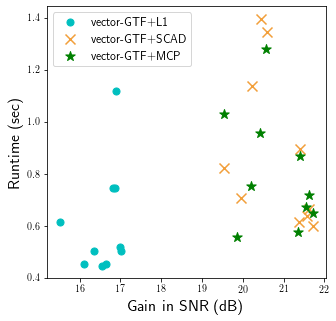

In [10]:
fig = plt.figure(figsize=(5,5))
plt.scatter(np.array(l1_snrs)-INPUT_SNR, l1_times, label='vector-GTF+L1', s=50, c='c')
plt.scatter(np.array(scad_snrs)-INPUT_SNR, np.array(l1_times)+np.array(scad_times), label='vector-GTF+SCAD', marker='x', s=100, c='#f29f3a')
plt.scatter(np.array(mcp_snrs)-INPUT_SNR, np.array(l1_times)+np.array(mcp_times), label='vector-GTF+MCP', marker='*',s=100,c='g')
plt.xlabel('Gain in SNR (dB)',fontsize=16)
plt.ylabel('Runtime (sec)',fontsize=16)
plt.legend(fontsize='large')
fig.savefig('2d-grid-runtime.pdf',format = 'pdf',bbox_inches='tight')

# Minnesota runtime

In [12]:
data = pd.read_csv('../datasets/minnesota/minnesota-simulation-19-01-09-03-56.csv',
                       skiprows=3,
                      names=['input_snr (dB)', 'sigma_sq', 'penalty_f', 'gamma_mult', 'rho_mult', 'penalty_param',
                              'avg output_snr (dB)'] + [str(e) for e in range(10)])
print(data)

input_snr = np.array(sorted(list(set(data['input_snr (dB)'].values))))

L1 = data.loc[data['penalty_f'] == 'L1', ['gamma_mult', 'rho_mult']].values
SCAD = data.loc[data['penalty_f'] == 'SCAD-L1', ['gamma_mult', 'rho_mult']].values
MCP = data.loc[data['penalty_f'] == 'MCP-L1', ['gamma_mult', 'rho_mult']].values
    
L1_vec = L1[range(0,len(L1),2)]
SCAD_vec = SCAD[range(0,len(SCAD),2)]
MCP_vec = MCP[range(0,len(MCP),2)]
    
L1 = L1[range(1,len(L1),2)]
SCAD = SCAD[range(1,len(SCAD),2)]
MCP = MCP[range(1,len(MCP),2)]
    

    input_snr (dB)  sigma_sq penalty_f  gamma_mult  rho_mult  penalty_param  \
0              -10   44.1938        L1      0.7725    0.1636            0.0   
1              -10   44.1938        L1      0.4085    0.1567            0.0   
2              -10   44.1938   SCAD-L1     63.1302   10.8704            3.7   
3              -10   44.1938   SCAD-L1     63.4909   19.6460            3.7   
4              -10   44.1938    MCP-L1    146.0735   19.7557            1.4   
5              -10   44.1938    MCP-L1     93.4036   19.5608            1.4   
6               -5   13.9753        L1      1.3504    4.1660            0.0   
7               -5   13.9753        L1      0.6381    1.3307            0.0   
8               -5   13.9753   SCAD-L1      2.5162    0.7747            3.7   
9               -5   13.9753   SCAD-L1    142.2719   19.5464            3.7   
10              -5   13.9753    MCP-L1    130.2446    2.5336            1.4   
11              -5   13.9753    MCP-L1    124.4601  

In [10]:
name = 'minnesota'
G = pg.graphs.Minnesota(connect=True) 
Gnx = nx.from_scipy_sparse_matrix(G.A.astype(float), edge_attribute='weight') 
y_true = np.load('../datasets/minnesota/beta_0.npy')
n = nx.number_of_nodes(Gnx)
k = 0
Dk = penalty_matrix(Gnx, k)
print ('n =', n,  'm =', Gnx.number_of_edges())
print ('sparsity', np.count_nonzero(Dk*y_true))

n = 2642 m = 3304
sparsity 83


In [11]:
DTD = Dk.T.dot(Dk).toarray()
[S, V] = np.linalg.eigh(DTD)

In [12]:
num_trial = 10
max_evals = 30
d = 20
pspace = (
    hp.loguniform('gamma_mult', -3, 5),
    hp.loguniform('rho_mult', -3, 3)
)

idx = 6

INPUT_SNR = input_snr[idx]
print(INPUT_SNR)

Ys = []
scad_opts = []
mcp_opts = []

y_true_norm_sq = np.linalg.norm(y_true, 2) ** 2
sigma_sq = y_true_norm_sq/(10**(INPUT_SNR/10.0))/n

for trial in range(num_trial):
    Y = np.tile(y_true.reshape(-1, 1), (1, d)) + np.random.normal(scale=np.sqrt(sigma_sq), size=(n, d))
    Ys.append(Y)
    ses = np.linalg.norm(Y - np.tile(y_true.reshape(-1, 1), (1, d)), 2, axis=0) ** 2

    mse = np.mean(ses)
    mean_snr = 10*np.log10(y_true_norm_sq/mse)
    
    print ('sigma squared:', sigma_sq)
    print ('input signal MSE:', mse)
    print ('input signal SNR:', mean_snr)

# opt_param, B_hat, snr_avg, penalty_param, output_snr = autotune_denoising(Gnx, Y, y_true.reshape(-1,1), 0,
#                                                                                           'L1', sigma_sq,
#                                                                                           max_evals, pspace,
#                                                                                           B_init=None, vec=True)

    res = admm_denoising_snr(L1_vec[idx], Y, sigma_sq, y_true, Dk, 'L1', eig=(S, V), B_init=None, vec=True)

    B_hat = res['B']
    l1_snr = -res['loss']
    mse = res['mse']
    
    print ('L1 vec MSE:', mse)
    print ('L1 vec SNR:', l1_snr)


    l1_B = B_hat.copy()

    opt_param, B_hat, snr_avg, penalty_param, output_snr = autotune_denoising(Y, y_true.reshape(-1,1), Dk,
                                                                                          'SCAD', sigma_sq,
                                                                                          max_evals, pspace,eig=(S, V),
                                                                                          B_init=l1_B, vec=True)
    scad_opts.append(opt_param.copy())
     
    opt_param, B_hat, snr_avg, penalty_param, output_snr = autotune_denoising(Y, y_true.reshape(-1,1), Dk,
                                                                                          'MCP', sigma_sq,
                                                                                          max_evals, pspace,eig=(S, V),
                                                                                          B_init=l1_B, vec=True)
    mcp_opts.append(opt_param.copy())

20
sigma squared: 0.04419379258137775
input signal MSE: 116.28172270773021
input signal SNR: 20.017826291195547
L1 vec MSE: 5.669266964805986
L1 vec SNR: 33.13767177991045
100%|██████████| 30/30 [06:41<00:00, 24.63s/it, best loss: -43.90870256285072] 
sigma squared: 0.04419379258137775
input signal MSE: 116.08327045539836
input signal SNR: 20.02524451180536
L1 vec MSE: 5.392083729944801
L1 vec SNR: 33.3553745887724
100%|██████████| 30/30 [08:13<00:00, 17.20s/it, best loss: -43.904481972752045]
sigma squared: 0.04419379258137775
input signal MSE: 117.50275968270603
input signal SNR: 19.9724601970059
L1 vec MSE: 5.740300397970344
L1 vec SNR: 33.083594660839914
100%|██████████| 30/30 [07:16<00:00, 25.25s/it, best loss: -38.764425594627184]
sigma squared: 0.04419379258137775
input signal MSE: 117.31259754879481
input signal SNR: 19.979494352220676
L1 vec MSE: 5.7141678755393155
L1 vec SNR: 33.10341091020146
100%|██████████| 30/30 [05:47<00:00, 14.57s/it, best loss: -47.03811835646353]
sigm

In [16]:
scad_opts
mcp_opts

idx = 6 # Input SNR = 20dB

l1_times = []
scad_times = []
mcp_times = []
l1_snrs = []
scad_snrs = []
mcp_snrs = []

ses = np.linalg.norm(Y - np.tile(y_true.reshape(-1, 1), (1, d)), 2, axis=0) ** 2

mse = np.mean(ses)
mean_snr = 10*np.log10(y_true_norm_sq/mse)
    
print ('sigma squared:', sigma_sq)
print ('input signal MSE:', mse)
print ('input signal SNR:', mean_snr)

for trial in range(num_trial):
    scad_opt = scad_opts[trial]
    mcp_opt = mcp_opts[trial]
    Y = Ys[trial]
    PARAM_GRID = [
            {'penalty_f': ["L1"], 'gamma_ratio': [L1_vec[idx,0]], 'rho_ratio': [L1_vec[idx,1]], 'penalty_param': [0]},
            {'penalty_f': ["SCAD"], 'gamma_ratio': [scad_opt['gamma_mult']], 'rho_ratio': [scad_opt['rho_mult']], 'penalty_param': [3.7]},
            {'penalty_f': ["MCP"], 'gamma_ratio': [mcp_opt['gamma_mult']], 'rho_ratio': [mcp_opt['rho_mult']], 'penalty_param': [1.4]}
        ]
    for params in ParameterGrid(PARAM_GRID):
        penalty_f = params['penalty_f']
        gamma = params['gamma_ratio']*sigma_sq
        penalty_param = params['penalty_param']

        if penalty_f == 'L1':
            l1_beta = None
            rho = params['rho_ratio']*gamma
        else:
            rho = max(params['rho_ratio']*gamma, 1/penalty_param)

        print (penalty_f, gamma, rho, penalty_param)

        t = time()
        invX = V.dot(np.diag(1/(1+rho*S))).dot(V.T)
        B, obj, err_path = admm(Y, gamma, rho, Dk, penalty_f, penalty_param,max_iter=500, tol_abs=10 ** (-3), 
                               tol_rel=10 ** (-2), B_init=l1_beta, invX=invX)
        t1 = time()-t
        
        ses = np.linalg.norm(B - np.tile(y_true.reshape(-1, 1), (1, d)), 2, axis=0) ** 2
        mse = np.mean(ses)
        snr = 10*np.log10(y_true_norm_sq/mse)

        if penalty_f == 'L1':
            l1_times.append(t1)
            l1_beta = B
            l1_snrs.append(snr)
        elif penalty_f == 'SCAD':
            scad_times.append(t1)
            scad_snrs.append(snr)
        else:
            mcp_times.append(t1)
            mcp_snrs.append(snr)

        print (penalty_f)
        print ('output signal MSE:', mse)
        print ('output signal SNR:', snr)
        print ('iteration:', np.shape(err_path[3]))

[{'gamma_mult': 140.4774489307071, 'rho_mult': 1.6213601463049063},
 {'gamma_mult': 136.43107850030668, 'rho_mult': 1.4946109050922964},
 {'gamma_mult': 146.79815940940836, 'rho_mult': 2.593740505092685},
 {'gamma_mult': 117.68983206081035, 'rho_mult': 2.898564835803327},
 {'gamma_mult': 145.2083726635658, 'rho_mult': 3.4406907958173925},
 {'gamma_mult': 80.01140335584057, 'rho_mult': 3.105911538008845},
 {'gamma_mult': 76.8992951175442, 'rho_mult': 3.9444993814374727},
 {'gamma_mult': 146.66575230614012, 'rho_mult': 1.4215590632021096},
 {'gamma_mult': 141.1612320219524, 'rho_mult': 2.097427157831775},
 {'gamma_mult': 135.0284499818782, 'rho_mult': 1.8943562564983663}]

[{'gamma_mult': 141.27143414687043, 'rho_mult': 0.6900637878333573},
 {'gamma_mult': 80.99869203700207, 'rho_mult': 1.2945946792672984},
 {'gamma_mult': 45.26177790637451, 'rho_mult': 0.3139051491806936},
 {'gamma_mult': 139.59107806815706, 'rho_mult': 1.2687094885406511},
 {'gamma_mult': 43.63817916509491, 'rho_mult': 1.2947653972972517},
 {'gamma_mult': 62.768591754739994, 'rho_mult': 0.8739865030579489},
 {'gamma_mult': 28.999084817746855, 'rho_mult': 1.0993674505816262},
 {'gamma_mult': 37.20048104582307, 'rho_mult': 0.8922786314602457},
 {'gamma_mult': 62.59088556360559, 'rho_mult': 1.586730818081994},
 {'gamma_mult': 146.13964976480858, 'rho_mult': 1.7445244625396426}]

sigma squared: 0.04419379258137775
input signal MSE: 116.31515550999556
input signal SNR: 20.016577806542646
L1 0.8393417668433006 7.477276129923544 0
L1
output signal MSE: 5.669266964805986
output signal SNR: 33.13767177991045
iteration: (52,)
SCAD 6.208231240404755 10.065778712237345 3.7
SCAD
output signal MSE: 0.24502333447565028
output signal SNR: 46.78086640516967
iteration: (38,)
MCP 6.243320458360557 4.3082893641537785 1.4
MCP
output signal MSE: 0.47470502615301813
output signal SNR: 43.90870256285072
iteration: (22,)
L1 0.8393417668433006 7.477276129923544 0
L1
output signal MSE: 5.392083729944801
output signal SNR: 33.3553745887724
iteration: (52,)
SCAD 6.029406784896219 9.011617131943371 3.7
SCAD
output signal MSE: 0.29505103863225796
output signal SNR: 45.97396938544265
iteration: (35,)
MCP 3.579639395246163 4.634182114781293 1.4
MCP
output signal MSE: 0.47516658145173807
output signal SNR: 43.904481972752045
iteration: (32,)
L1 0.8393417668433006 7.477276129923544 0
L1
outp

In [17]:
l1_times
scad_times
mcp_times
l1_snrs
scad_snrs
mcp_snrs
np.savez('minnesota-runtime'+'.npz', l1_times=l1_times, scad_times=scad_times, mcp_times=mcp_times, 
         l1_snrs=l1_snrs, scad_snrs=scad_snrs, mcp_snrs=mcp_snrs, scad_opts=scad_opts, mcp_opts=mcp_opts, 
        Ys=Ys, input_snr=INPUT_SNR)

[7.580904245376587,
 7.2566752433776855,
 6.836250066757202,
 6.927603006362915,
 6.7369489669799805,
 6.966160774230957,
 6.606335878372192,
 6.747577905654907,
 6.9270570278167725,
 7.115587949752808]

[5.341256380081177,
 4.859194040298462,
 7.01589298248291,
 10.355015993118286,
 14.445314645767212,
 9.923240184783936,
 11.524209976196289,
 4.892420291900635,
 6.257377862930298,
 5.464836835861206]

[3.3509981632232666,
 4.587734937667847,
 3.6941120624542236,
 8.091553211212158,
 58.67125988006592,
 2.905949115753174,
 58.19444990158081,
 2.963503122329712,
 4.051483154296875,
 9.111088991165161]

[33.13767177991045,
 33.3553745887724,
 33.083594660839914,
 33.10341091020146,
 33.25117753970848,
 33.27363612961901,
 33.349712080903615,
 33.44227855430074,
 33.345827830023254,
 33.47649679284584]

[46.78086640516967,
 45.97396938544265,
 48.14785197700323,
 47.70647420821572,
 47.1029750276221,
 48.88477507439896,
 47.022862855041026,
 46.364763159807026,
 46.764858207535525,
 47.54952700365628]

[43.90870256285072,
 43.904481972752045,
 38.764425594627184,
 47.03811835646353,
 44.843583300628104,
 42.351755925393526,
 40.36277401692796,
 40.00047403299391,
 44.18894980186333,
 45.19294690220932]

Text(0.5, 0, 'Gain in SNR (dB)')

Text(0, 0.5, 'Runtime (sec)')

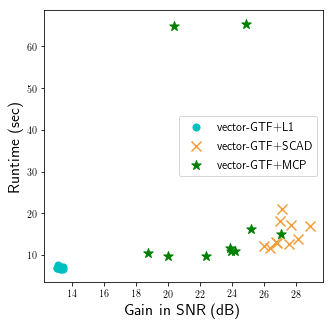

In [18]:
fig = plt.figure(figsize=(5,5))
plt.scatter(np.array(l1_snrs)-INPUT_SNR, l1_times, label='vector-GTF+L1', s=50, c='c')
plt.scatter(np.array(scad_snrs)-INPUT_SNR, np.array(l1_times)+np.array(scad_times), label='vector-GTF+SCAD', marker='x', s=100, c='#f29f3a')
plt.scatter(np.array(mcp_snrs)-INPUT_SNR, np.array(l1_times)+np.array(mcp_times), label='vector-GTF+MCP', marker='*',s=100,c='g')
plt.xlabel('Gain in SNR (dB)',fontsize=16)
plt.ylabel('Runtime (sec)',fontsize=16)
plt.legend(fontsize='large')
fig.savefig('minnesota-runtime.pdf',format = 'pdf',bbox_inches='tight')